<a href="https://colab.research.google.com/github/wisabd/CreditFraudML/blob/main/FeatureEngineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install boto3
!pip install sagemaker  # Installs boto3 as a dependency

from google.colab import userdata
import os
import warnings


# Set credentials as environment variables (they're loaded from Colab secrets)
os.environ['AWS_ACCESS_KEY_ID'] = userdata.get('AWS_ACCESS_KEY_ID')
os.environ['AWS_SECRET_ACCESS_KEY'] = userdata.get('AWS_SECRET_ACCESS_KEY')
aws_account_id = userdata.get('AWS_ACCOUNT_ID')  # Your stored account ID
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'  # Set your region

# Initialize boto3/SageMaker session and Define IAM role
import boto3
import re
import sagemaker
import seaborn as sns


# Suppress warnings (optional)
warnings.filterwarnings('ignore', category=UserWarning, module='sagemaker')

role_name = 'SageMaker-Execution-Role'  # Your role name

# Construct the full Role ARN
role_arn = f'arn:aws:iam::{aws_account_id}:role/{role_name}'
try:
    role = sagemaker.get_execution_role();  # Works in SageMaker notebooks
except ValueError:
    role = role_arn  # Fallback for Colab


#Manage interactions with the Amazon SageMaker APIs and any other AWS services needed.
#manipulating entities and resources that Amazon SageMaker uses, such as training jobs, endpoints, and input datasets in S3.

session = boto3.Session()  # Automatically picks up env variables
sm_session = sagemaker.Session(boto_session=session)
bucket = sm_session.default_bucket()

In [8]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer

predictor = Predictor(endpoint_name="your-endpoint-name")
predictor.serializer = CSVSerializer()

pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_columns', 500)
!pip install imblearn graphviz xgboost

In [26]:
credit_df = pd.read_csv('creditcard.csv')
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0


In [27]:
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


In [28]:
print('The number of Non-Frauds are: ' + str(credit_df['Class'].value_counts()[0]) + ' which is ', round(credit_df['Class'].value_counts()[0]/len(credit_df) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(credit_df['Class'].value_counts()[1]) + ' which is ', round(credit_df['Class'].value_counts()[1]/len(credit_df) * 100,2), '% of the dataset')

The number of Non-Frauds are: 284315 which is  99.83 % of the dataset
The number of Frauds are: 492 which is  0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

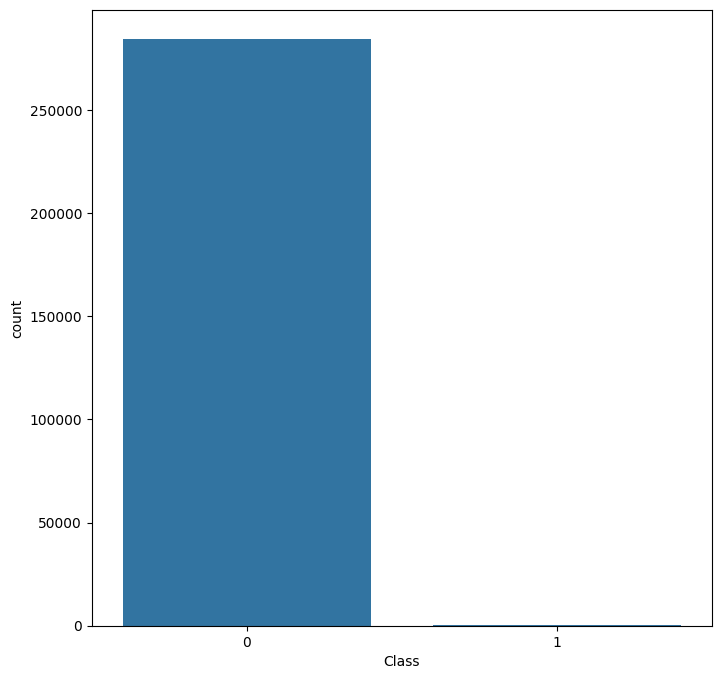

In [29]:
plt.figure(figsize=(8, 8))
sns.countplot(x= 'Class', data=credit_df)

In [30]:
credit_df.isna().sum()


,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


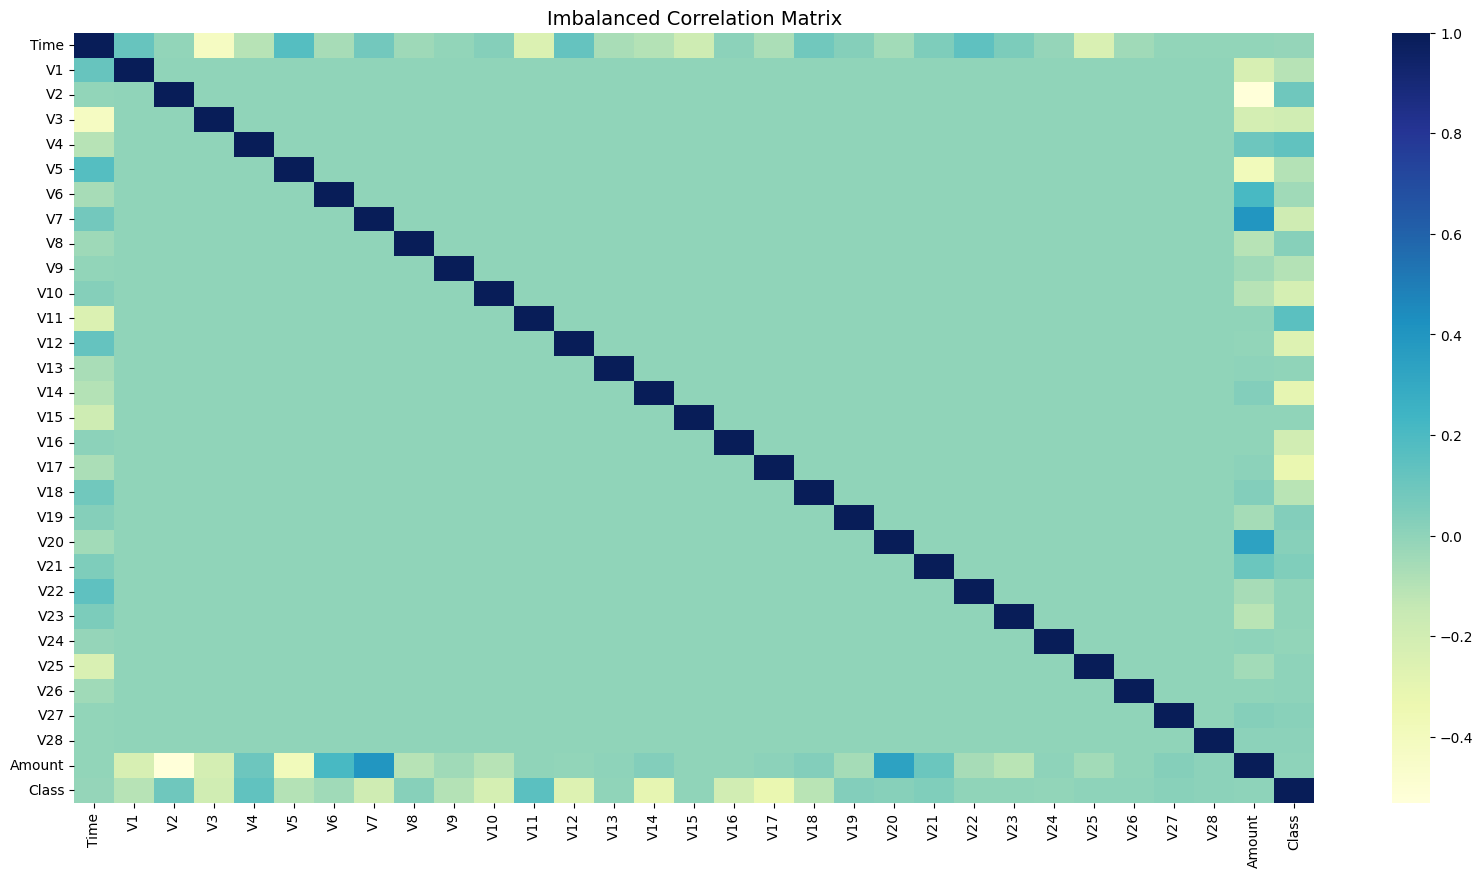

In [31]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = credit_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

In [32]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import RobustScaler

# RobustScaler is robust to outliers.

credit_df['amount_after_scaling'] = RobustScaler().fit_transform(credit_df['Amount'].values.reshape(-1,1))
credit_df['time_after_scaling'] = RobustScaler().fit_transform(credit_df['Time'].values.reshape(-1,1))

credit_df.drop(['Time','Amount'], axis=1, inplace=True)

# Place the class in the begining of the dataframe
Class = credit_df['Class']
credit_df.drop(['Class'], axis=1, inplace=True)
credit_df.insert(0, 'Class', Class)

In [33]:
credit_df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,0.001727,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.927124,0.118914
std,0.041527,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.088850,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,3.495006,0.557903
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,-0.307413,-0.994983
25%,0.000000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.498850,-0.456299,-0.211721,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,-0.229162,-0.358210
50%,0.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,0.000000,0.000000
75%,0.000000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.493150,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,0.770838,0.641790
max,1.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,358.683155,1.035022


In [34]:
# Shuffle the Dataset.
shuffled_df = credit_df.sample(frac=1,random_state=4)

# amount of fraud classes 492 rows.
fraud_df = shuffled_df.loc[shuffled_df['Class'] == 1]

#Randomly select 492 observations.
non_fraud_df = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=492,random_state=42)
normalized_df = pd.concat([fraud_df, non_fraud_df])

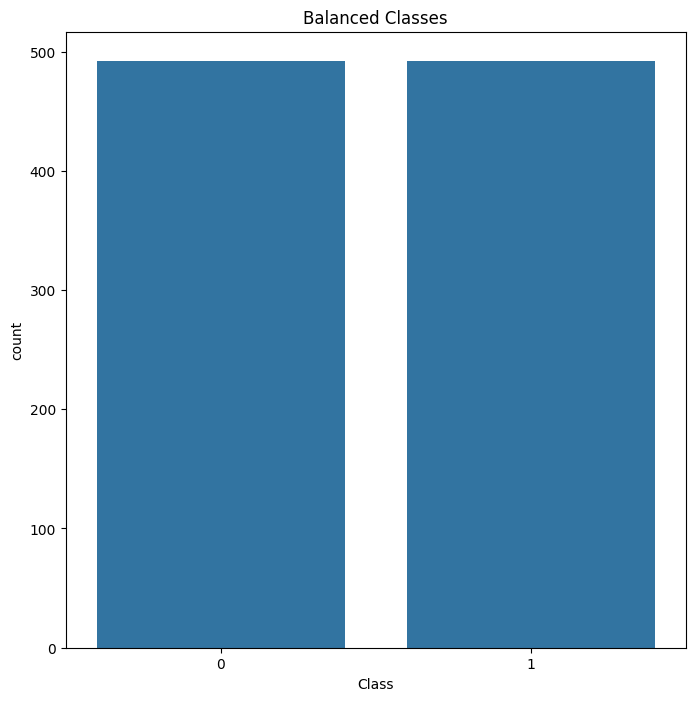

In [35]:
plt.figure(figsize=(8, 8))
sns.countplot(x = 'Class', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [37]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy='minority', random_state=7)

oversampled_trainX, oversampled_trainY = sm.fit_resample(credit_df.drop('Class', axis=1), credit_df['Class'])
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = normalized_df.columns

In [38]:
normalized_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
9179,1,-2.880042,5.225442,-11.063330,6.689951,-5.759924,-2.244031,-11.199975,4.014722,-3.429304,-11.561950,10.446847,-15.479052,0.734442,-13.883779,0.821440,-11.911483,-18.103004,-6.837835,3.126929,1.191444,2.002883,0.351102,0.795255,-0.778379,-1.646815,0.487539,1.427713,0.583172,-0.293440,-0.840776
223618,1,-2.006582,3.676577,-5.463811,7.232058,-1.627859,-0.996755,-4.299833,2.268867,-3.651067,-4.400930,4.213213,-5.737815,-0.875693,-8.893726,-0.562434,-3.281784,-4.368986,-0.736734,1.609293,0.474414,0.713907,-0.063868,0.167947,-0.449864,0.023702,0.536905,0.485864,-0.042393,-0.293440,0.690375
9487,1,-4.153014,8.204797,-15.031714,10.330100,-3.994426,-3.250013,-10.415698,4.620804,-5.711248,-11.797181,11.277921,-16.728339,0.241368,-17.721638,-0.387300,-10.322017,-13.959085,-5.030710,1.197266,1.412625,1.976988,0.256510,0.485908,-1.198821,-0.526567,0.634874,1.627209,0.723235,-0.293440,-0.829650
10497,1,1.189784,0.942289,0.082334,3.024050,0.412406,-0.214415,0.053558,-0.110353,0.883798,-0.554224,0.154921,-2.776757,1.641207,-0.456077,-1.240414,0.857323,1.707024,0.526349,-0.865105,-0.143435,-0.502636,-1.047398,-0.056752,-0.340688,0.541235,-0.098300,-0.003041,0.049819,-0.254454,-0.792678
250761,1,-0.512349,4.827060,-7.973939,7.334059,0.367704,-2.055129,-2.935856,1.431008,-4.544722,-5.258096,5.716319,-5.810407,0.723293,-12.289133,0.378773,-2.020734,-2.039703,0.658183,0.832574,0.804101,0.535620,-0.459496,-0.009364,-1.140436,-0.006445,0.527970,0.558881,0.126517,-0.296653,0.826631


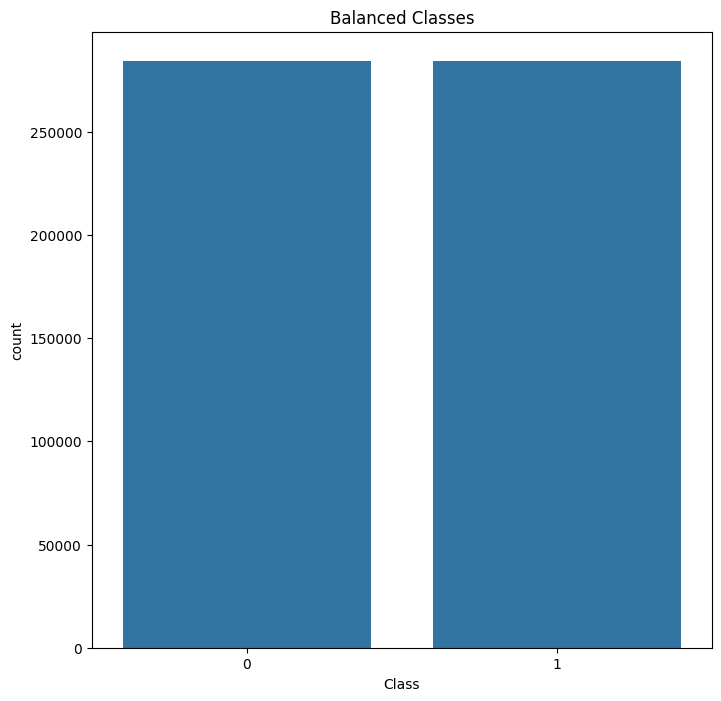

In [40]:
plt.figure(figsize=(8, 8))
sns.countplot(x='Class', data=oversampled_train)
plt.title('Balanced Classes')
plt.show()

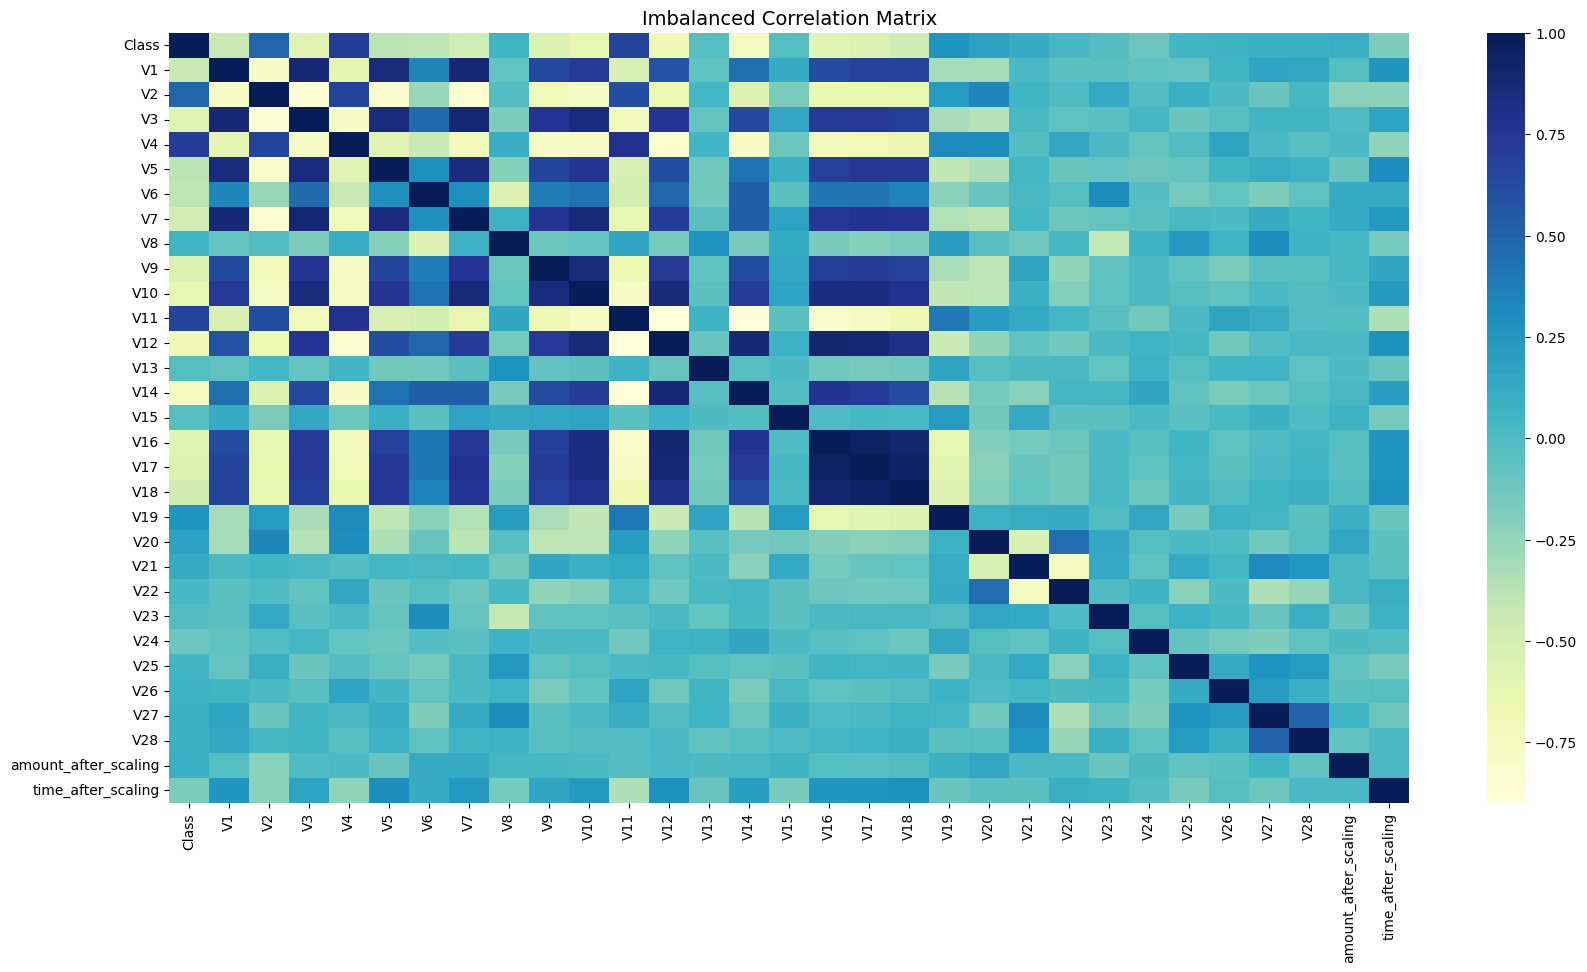

In [41]:
fig, ax = plt.subplots(figsize=(20,10))

# Imbalanced DataFrame Correlation
corr = normalized_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

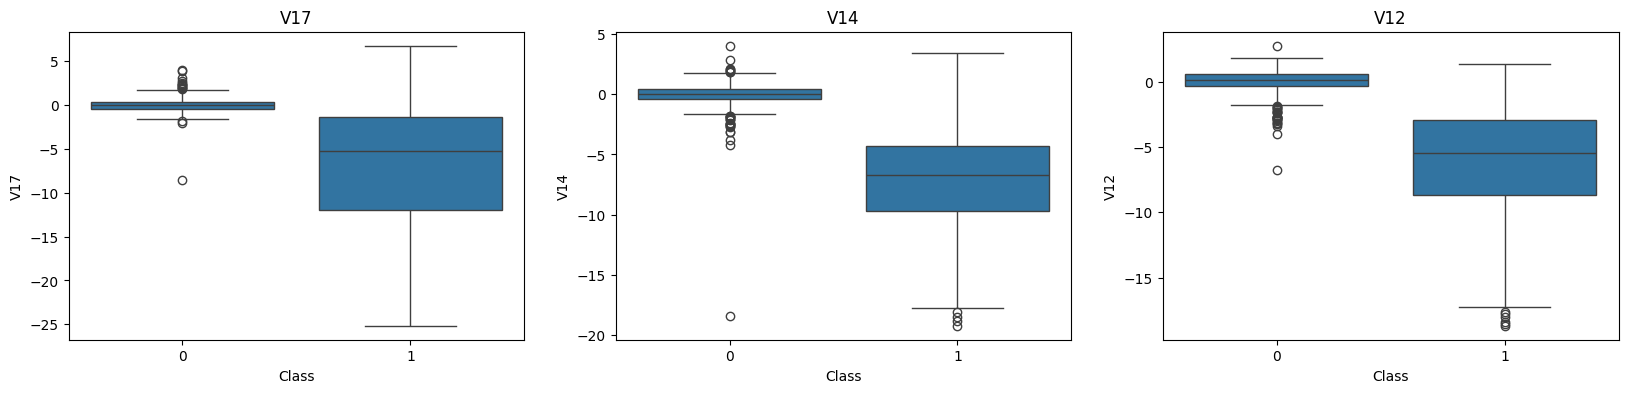

In [42]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=normalized_df, ax=axes[0])
axes[0].set_title('V17')

sns.boxplot(x="Class", y="V14", data=normalized_df, ax=axes[1])
axes[1].set_title('V14')


sns.boxplot(x="Class", y="V12", data=normalized_df, ax=axes[2])
axes[2].set_title('V12')


plt.show()

In [43]:
V17_non_fraud = normalized_df.query('V17 > -7 & Class == 0')
V17_fraud = normalized_df.query('Class == 1')
normalized_df_no_outlier = pd.concat([V17_non_fraud,V17_fraud])

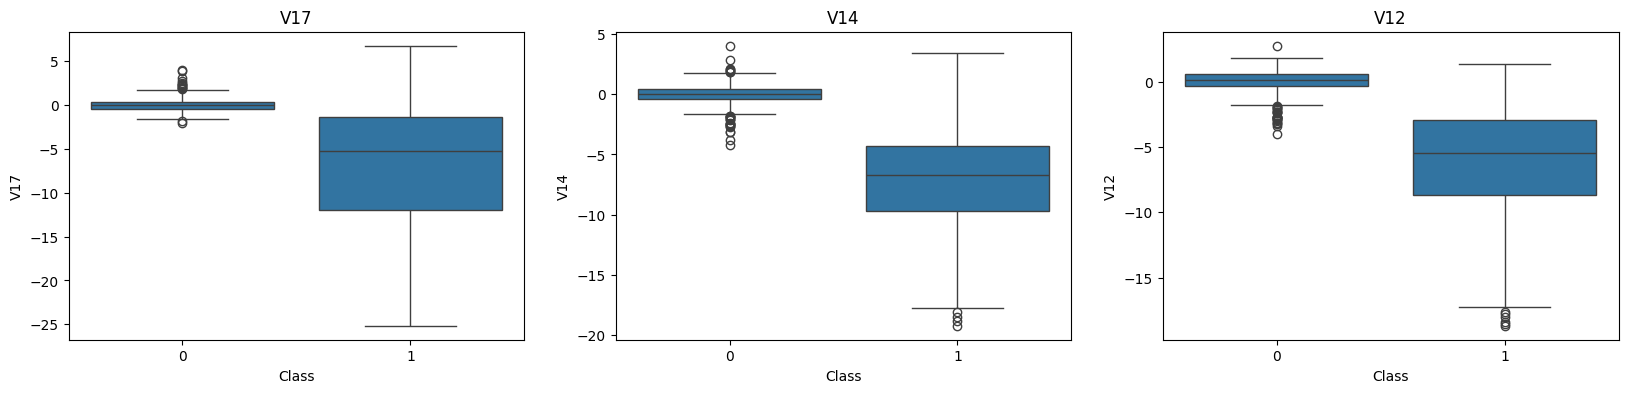

In [44]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=normalized_df_no_outlier, ax=axes[0])
axes[0].set_title('V17')

sns.boxplot(x="Class", y="V14", data=normalized_df_no_outlier, ax=axes[1])
axes[1].set_title('V14')


sns.boxplot(x="Class", y="V12", data=normalized_df_no_outlier, ax=axes[2])
axes[2].set_title('V12')


plt.show()

In [45]:
shuffled_normalized_df = normalized_df.sample(frac=1)
shuffled_normalized_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount_after_scaling,time_after_scaling
249607,1,-7.381547,-7.449015,-4.696287,3.728439,6.198304,-6.406267,-5.831452,1.457175,-0.646203,-4.029129,2.528943,-3.308722,-1.992010,-5.757216,-0.877323,-1.547552,-1.909017,0.500567,0.136722,2.932758,1.176575,-0.978692,-0.278330,-0.635874,0.123539,0.404729,0.704915,-1.229992,0.181653,0.820040
91440,0,-0.461664,0.907214,1.262356,-0.081328,0.214163,-0.234337,0.442491,0.273467,-0.501101,-0.355420,1.531217,0.152255,-1.007462,0.001216,0.559499,0.334782,0.094183,0.036468,-0.152390,0.044690,-0.191294,-0.549333,0.028787,-0.061866,-0.294831,0.087640,0.249146,0.083522,-0.223713,-0.249298
8845,1,-4.727713,3.044469,-5.598354,5.928191,-2.190770,-1.529323,-4.487422,0.916392,-1.307010,-4.138891,5.149409,-11.124019,0.543068,-7.840942,0.743634,-6.777069,-9.931765,-4.093021,1.504925,-0.207759,0.650988,0.254983,0.628843,-0.238128,-0.671332,-0.033590,-1.331777,0.705698,0.117236,-0.852888
204503,1,-3.158990,1.765452,-3.390168,0.987410,-1.509930,-1.280952,-2.719557,0.718325,-1.660183,-3.841098,3.282825,-3.906877,0.951368,-4.898183,-0.552000,-4.787448,-9.334329,-2.580249,1.501573,-0.022590,1.120533,1.605085,-0.618637,-0.251283,-0.240528,-0.004327,-0.235477,0.018129,0.870258,0.594720
11710,1,-14.724627,7.875157,-21.872317,11.906170,-8.348734,-2.262846,-15.833443,0.077874,-6.356833,-13.261652,10.063790,-14.394767,0.654889,-14.248316,-0.305361,-8.161632,-12.280965,-4.818586,0.719788,0.996469,-2.362345,1.099557,1.037199,-1.036359,-0.254777,0.642343,2.161129,-1.401282,-0.293440,-0.759889


In [47]:
train_data, validation_data, test_data = np.split(shuffled_normalized_df, [int(0.7 * len(shuffled_normalized_df)), int(0.9 * len(shuffled_normalized_df))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

In [49]:
prefix = 'sagemaker/project-name'
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [50]:
%store train_data
%store validation_data
%store test_data
%store shuffled_normalized_df

Stored 'train_data' (DataFrame)
Stored 'validation_data' (DataFrame)
Stored 'test_data' (DataFrame)
Stored 'shuffled_normalized_df' (DataFrame)
